핸즈온 머신러닝 2강 : 머신러닝 처음부터 끝까지 

머신러닝 프로젝트 진행의 전반적인 과정을 이해하는 것을 목적으로 한다. 데이터 전처리와 모델링, 그리고 평가로 이루어져 있다. 

데이터는 교재의 캘리포니아 주택가격 데이터가 아닌, 우리나라 아파트 데이터를 사용한다. 서울과 부산지역 아파트의 실거래가를 예측하는 모델을 개발하고, 이를 평가해본다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from pandas.plotting import scatter_matrix
from tqdm import tqdm
import re

# 데이터 불러오고 살펴보기

In [3]:
#데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Transaction_price_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Transaction_price_data/test.csv')

In [4]:
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- 범주형 변수, 숫자형 변수로 나뉜것을 볼 수 있음. 
- 범주형 변수에 대해서는 value_counts()로 카테고리 별 값을 확인할 수 있음.
- 양적 변수에 대해서는 히스토그램이나 산점도로 시각화해서 분포를 확인할 수 있음.

In [6]:
train.city.value_counts() #범주형변수

서울특별시    742285
부산광역시    474268
Name: city, dtype: int64

In [7]:
train.floor.describe() #숫자형

count    1.216553e+06
mean     9.343291e+00
std      6.606500e+00
min     -4.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      8.000000e+01
Name: floor, dtype: float64

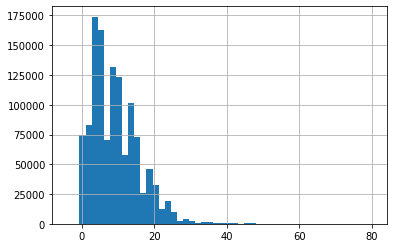

In [8]:
train.floor.hist(bins=50)
plt.show() #히스토그램으로 확인

test 데이터셋도 살펴보자


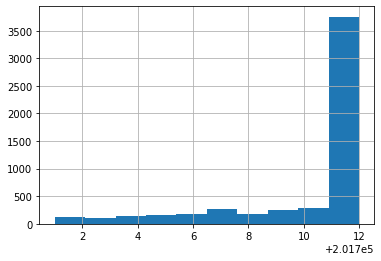

In [9]:
test.transaction_year_month.hist()

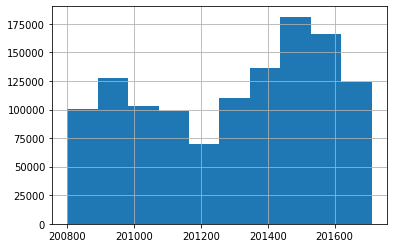

In [10]:
train.transaction_year_month.hist()

x축을 보면 숫자가 약간 다름. test set의 데이터들은 전부 2017년에만 거래된 데이터들. 나중에 전처리할때 이부분도 같이 체크해주어야 함. 지금은 일단 살펴보는 단계라서 pass

**변수 설명**
- transaction_real_price : 실거래가


- exclusice_use_area : 전용면적
- year_of_completion : 완공된 해
- transaction_year_month : 거래년월
- transaction_date : 거래일
- floor : 층

In [11]:
#데이터 모양 살펴보기, 차례로 행, 열
print(train.shape)
print(test.shape)

(1216553, 13)
(5463, 12)


이 데이터셋은 테스트 세트와 훈련 세트가 이미 나누어져 있는 데이터지만, 자체 검증을 위해 훈련 세트를 다시 나누어야 함. 훈련 세트 내에서 다시 '진짜' 훈련에 사용할 데이터와, 검증에 사용할 데이터를 나누어야 함

### 무작위 샘플링

In [12]:
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(973242, 13)
(243311, 13)


### 계층적 샘플링
부산과 서울의 가격이 다를 수 있음. 각 비율에 맞춰 샘플링을 진행하는게 좋지 않을까?

In [13]:
train.city.value_counts()

서울특별시    742285
부산광역시    474268
Name: city, dtype: int64

텍스트를 숫자로 변환하는 과정이 필요! -> 인코더 사용

In [14]:
train_city = train[['city']]
ordinal_encoder = OrdinalEncoder()

train_city_encoded = ordinal_encoder.fit_transform(train_city)
train_city_encoded[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [15]:
ordinal_encoder.categories_ #카테고리 특성 확인

[array(['부산광역시', '서울특별시'], dtype=object)]

In [16]:
train[['city']] = train_city_encoded #인코딩 된 값으로 바꿔주고

In [17]:
train[['city']].value_counts #값이 변환된 것을 볼 수 있음.

<bound method DataFrame.value_counts of          city
0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
...       ...
1216548   0.0
1216549   0.0
1216550   0.0
1216551   0.0
1216552   0.0

[1216553 rows x 1 columns]>

In [18]:
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,1.0,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,1.0,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,1.0,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,1.0,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,1.0,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


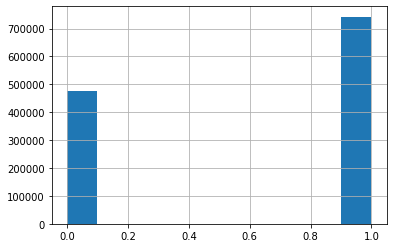

In [19]:
#train_test_split 이제 해보자

train.city.hist() #비율이 다름

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=10)
for train_idx, test_idx in split.split(train, train['city']):
  strat_train_set = train.loc[train_idx]
  strat_test_set = train.loc[test_idx]

In [21]:
#계층적 샘플링 했을때 서울, 부산 각각의 데이터 개수
strat_train_set['city'].value_counts()

1.0    593828
0.0    379414
Name: city, dtype: int64

In [22]:
#무작위 샘플링
train_set['city'].value_counts()

서울특별시    593666
부산광역시    379576
Name: city, dtype: int64

In [23]:
#상관계수 확인 - corr() 숫자 확인

corr_matrix = train.corr()
corr_matrix['transaction_real_price'].sort_values(ascending=False)

transaction_real_price    1.000000
exclusive_use_area        0.561563
city                      0.440886
transaction_year_month    0.183910
floor                     0.112278
year_of_completion        0.052656
apartment_id              0.017576
transaction_id           -0.120734
Name: transaction_real_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9836c2e50>,
      dtype=object)

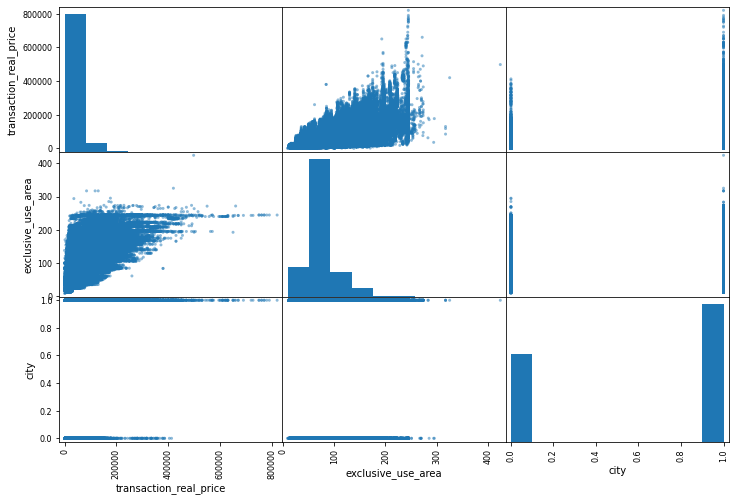

In [24]:
#상관계수 확인 - scatter_matrix 시각화

attributes = ['transaction_real_price', 'exclusive_use_area', 'city']
scatter_matrix(train[attributes], figsize=(12,8))

나머지 값들 사이에는 큰 관계 없는걸 볼 수 있고, 대각선은 그냥 각각의 히스토그램을 보여준거고, 맨 윗줄을 봐야하는데 exclusize_use_area가 약간의 선형성을 보여주고있음! 
city는 당연히 서울이 비쌀수밖에 없고,, 

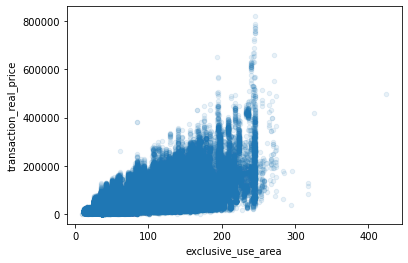

In [25]:
train.plot(kind='scatter', x='exclusive_use_area', y='transaction_real_price',
           alpha=0.1)

# 데이터 전처리

### apt

In [26]:
#다시 데이터를 확인해보자.
#exclusive_use_area가 유의미한 관계를 보인다는것 확인했고, city도 나름의 관계가 있었음. 
#적절한 특성 조합을 생각해보자!

train.apt.value_counts()

현대         13154
한신          9766
삼성          6729
대우          6216
신동아         5851
           ...  
(749-6)        1
메가트리움          1
애오개아이파크        1
예성그린           1
로미아트빌          1
Name: apt, Length: 10440, dtype: int64

apt 변수를 보자. 아파트 101동과 102동 간 가격 차이가 클까? -> 확인

In [27]:
#괄호, 괄호 내의 내용을 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train))):
  train.at[i,'apt'] = re.sub(regex, '', train.at[i,'apt'])
for i in tqdm(range(len(test))):
  test.at[i,'apt'] = re.sub(regex, '', test.at[i,'apt'])

100%|██████████| 5463/5463 [00:00<00:00, 56686.94it/s]


In [28]:
train['apt'].value_counts()[:20]

현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: apt, dtype: int64

아파트 많은 순서대로 정렬됨!
전체 데이터에서 생각보다 많은 아파트가 겹친다. 아파트 별로 몇 채가 있는지 나타내는 변수를 생성하자.

In [29]:
#같은 아파트 이름을 갖는 수로 새로운 피쳐 생성

train['apt_counts'] = 0

train.groupby('apt')['apt_counts'].count()
train = pd.merge(train, train.groupby('apt')['apt_counts'].count(),
                 on='apt', how='left').drop('apt_counts_x',axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test['apt_counts'] = 0

test.groupby('apt')['apt_counts'].count()
test = pd.merge(test, test.groupby('apt')['apt_counts'].count(),
                 on='apt', how='left').drop('apt_counts_x',axis=1).rename(columns={'apt_counts_y':'apt_counts'})

          

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  float64
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
 13  apt_counts              1216553 non-null  int64  
dtypes:

새로운 변수가 추가된 것을 볼 수 있음.
1개인 데이터들도 존재함. -> 아파트 이름이 비슷한 경우는 다 하나로 묶는게 나을듯! 가장 많이 나오는 아파트 상위 50개를 선정해 묶고, 나머지는 others로 처리해보자.

In [31]:
#데이터에 가장 많이 나오는 아파트의 리스트

apt_list = train.apt.value_counts()
type(apt_list) #시리즈를 데이터프레임으로 변환

pandas.core.series.Series

In [32]:
apt_frame = pd.DataFrame(apt_list)
apt_frame = apt_frame[:50]

In [33]:
apt_name = [ name for name in apt_frame.index]
apt_name

['현대',
 '한신',
 '삼성',
 '대우',
 '신동아',
 '두산',
 '우성',
 '주공2',
 '삼성래미안',
 '벽산',
 '대림',
 '동원로얄듀크',
 '경남',
 '삼환',
 '극동',
 '삼익',
 '롯데캐슬',
 '쌍용',
 '코오롱',
 '한양',
 '오륙도에스케이뷰',
 '성원',
 '파크리오',
 '청구',
 '몰운대',
 '동아',
 '경남아너스빌',
 '현대3',
 '삼정그린코아',
 '대림e-편한세상',
 '에스케이북한산시티',
 '다대동롯데캐슬몰운대',
 '주공5',
 '한진',
 '현대1',
 '미성',
 '엘지메트로시티1',
 '개포주공 1단지',
 '한일유앤아이',
 '삼익비치',
 '롯데낙천대',
 '사직쌍용예가',
 '중앙하이츠',
 '개금주공2',
 '잠실엘스',
 '리센츠',
 '중계그린1단지',
 '관악드림',
 '롯데',
 '쌍용스윗닷홈']

In [34]:
#아파트 이름이 apt_name에 들어가지 않으면, 아파트 명을 others로 변경

train['transformed'] = False
test['transformed'] = False

for a in tqdm(apt_name):
  train.loc[train['apt'].str.contains(a),'apt'] = a
  test.loc[test['apt'].str.contains(a), 'apt'] = a
  train.loc[train['apt'].str.contains(a), 'transformed'] = True
  test.loc[test['apt'].str.contains(a), 'transformed'] = True

for a in tqdm(apt_name):
  train.loc[~train['transformed'], 'apt'] = 'others'
  test.loc[~test['transformed'],'apt'] = 'others'

100%|██████████| 50/50 [00:01<00:00, 29.70it/s]


In [35]:
#다시 데이터 확인
train['apt'].value_counts()

others       730241
현대            84894
롯데            33190
삼성            32828
한신            27481
벽산            26968
동아            26162
우성            24524
대림            24063
두산            19501
대우            19035
삼익            18708
쌍용            16612
경남            10800
극동             9925
주공2            9912
한양             9376
한진             8625
청구             8618
코오롱            8602
성원             7601
삼환             6073
동원로얄듀크         6070
중앙하이츠          5559
미성             4725
삼정그린코아         4661
한일유앤아이         3558
오륙도에스케이뷰       3220
파크리오           3094
주공5            2977
몰운대            2886
에스케이북한산시티      2572
엘지메트로시티1       2359
개포주공 1단지       2356
잠실엘스           2258
리센츠            2234
중계그린1단지        2175
관악드림           2110
Name: apt, dtype: int64

깔끔하게~정리되엇답니다? _ 각 아파트의 평균 가격 보고, 내림차순 라벨 인코딩

In [36]:
apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
  train.loc[train['apt']==a, 'apt'] = i #라벨인코딩
  test.loc[test['apt'] ==a, 'apt'] = i

apt_price = train.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
잠실엘스        96498.002657
리센츠         92961.140555
파크리오        88739.646736
개포주공 1단지    88516.395161
삼성          47598.025557
Name: transaction_real_price, dtype: float64
변환후
 apt
0    96498.002657
1    92961.140555
2    88739.646736
3    88516.395161
4    47598.025557
Name: transaction_real_price, dtype: float64


### date

In [37]:
train.head(2)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,transformed
0,0,7622,1.0,신교동,6-13,17,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13,False
1,1,5399,1.0,필운동,142,17,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1,False


year_of_completion, transaction_year_month, transaction_date : 날짜 관련 컬럼들

In [38]:
print(min(train.year_of_completion))
print(max(train.year_of_completion))

1961
2017


In [39]:
print(min(train.transaction_year_month))
print(max(train.transaction_year_month))

200801
201711


In [40]:
test_start = train.loc[train['transaction_year_month'] == 201701, 'transaction_year_month'].index[0]

각각의 최대연도에서 최소연도를 빼면 정수형 라벨인코딩 가능! (따로 희소행렬이나, 원핫인코딩을 진행하지 않고 그냥 라벨인코딩만)

test data는 라벨인코딩을 할 때 주의해야 함. 거래연월이 2017년만 있기 때문에, 라벨 인코딩 값이 달라짐

test는 거래연월에서 2017을 뺀 값에서, 201701의 인코딩 값을 더해주는 과정을 거쳐야 함.


In [41]:
#완공연도 - 최소연도 빼서 완공연도 라벨인코딩
print('변환전\n', train['year_of_completion'].unique()[:5])
train['year_of_completion'] = train['year_of_completion'] - train['year_of_completion'].min()
test['year_of_completion'] = test['year_of_completion'] - test['year_of_completion'].min()
print('변환후\n', train['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train['transaction_year_month'].unique()[:5])
print('test 변환전\n', test['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train['transaction_year_month'] = le.fit_transform(train['transaction_year_month'])

# test는 다음과 같이 처리
test['transaction_year_month'] = test['transaction_year_month'] - test['transaction_year_month'].min() + train.at[test_start, 'transaction_year_month']
print('train 변환후\n', train['transaction_year_month'].unique()[:5])
print('test 변환후\n', test['transaction_year_month'].unique()[:5])

변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]
train 변환후
 [0 1 2 3 4]
test 변환후
 [118 115 117 114 119]


In [42]:
# 필요없는 열 제거
train = train.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
test = test.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

In [43]:
train.head(5)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,transformed
0,0,7622,1.0,신교동,17,84.82,41,0,2,37500,13,False
1,1,5399,1.0,필운동,17,99.17,12,0,6,20000,1,False
2,2,3578,1.0,필운동,17,84.74,46,0,6,38500,13,False
3,3,10957,1.0,내수동,17,146.39,42,0,15,118000,55,False
4,4,10639,1.0,내수동,17,194.43,43,0,3,120000,15,False


In [44]:
test

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,transformed
0,1145756,10453,서울특별시,목동,17,35.5500,41,118,2,1,False
1,1198704,989,부산광역시,초량동,17,68.7200,16,115,2,1,False
2,1222384,8597,부산광역시,괴정동,17,72.5400,28,117,2,1,False
3,1179897,11086,서울특별시,대치동,17,111.5400,43,114,10,2,False
4,1223091,2121,부산광역시,다대동,9,119.6398,53,119,21,3,True
...,...,...,...,...,...,...,...,...,...,...,...
5458,1174640,8965,서울특별시,양재동,17,84.0500,42,117,7,1,False
5459,1175575,3831,서울특별시,반포동,17,84.9300,48,119,4,2,False
5460,1157024,5550,서울특별시,구로동,4,110.1880,43,119,23,23,True
5461,1136863,3371,서울특별시,홍제동,17,92.4400,44,117,1,1,False


### dong

In [45]:
#같은 이름을 가진 동이 있는지 확인
seoul_set = set(train.loc[train['city']=='서울특별시', 'dong'])
busan_set = set(train.loc[train['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

seoul_set = set(test.loc[test['city']=='서울특별시', 'dong'])
busan_set = set(test.loc[test['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

set()
{'부암동', '사직동', '송정동', '중동'}


In [46]:
#위 네 동은 부산과 서울에 이름이 겹침. 앞에 서울특별시, 부산광역시를 붙여서 분리

for d in same_dong:
  train.loc[(train['city']=='서울특별시')&(train['dong']==d),'dong'] = '서울'+d
  train.loc[(train['city']=='부산광역시')&(train['dong']==d),'dong'] = '부산'+d
  test.loc[(test['city']=='서울특별시')&(test['dong']==d),'dong'] = '서울'+d
  test.loc[(test['city']=='부산광역시')&(test['dong']==d),'dong'] = '부산'+d



In [47]:
#다시 확인 -> 더 이상 겹치는 동이 없음
seoul_set = set(test.loc[test['city']=='서울특별시', 'dong'])
busan_set = set(test.loc[test['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

set()


In [48]:
#동별 평균 가격 확인
train[train['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

In [49]:
#동별로 가격차이가 많이 남. -> 동은 그대로 냅두자.. -> 어디가 젤 비쌈?

dong_price = train.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:20]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
도곡동       110655.655354
청담동       110289.411168
교남동       108600.000000
내수동       107899.014778
주성동       106000.000000
하중동       105900.477833
삼성동       101379.971621
잠실동       101166.337275
동자동        99472.876033
동빙고동       99057.552239
Name: transaction_real_price, dtype: float64

In [50]:
#라벨 인코딩 진행

for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
  train.loc[train['dong']==d, 'dong']=i
  test.loc[test['dong']==d, 'dong']=i
train.head(5)

100%|██████████| 473/473 [00:43<00:00, 10.90it/s]


,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,transformed
0,0,7622,1.0,137,17,84.82,41,0,2,37500,13,False
1,1,5399,1.0,64,17,99.17,12,0,6,20000,1,False
2,2,3578,1.0,64,17,84.74,46,0,6,38500,13,False
3,3,10957,1.0,13,17,146.39,42,0,15,118000,55,False
4,4,10639,1.0,13,17,194.43,43,0,3,120000,15,False


### floor

In [51]:
train.floor.describe()

count    1.216553e+06
mean     9.343291e+00
std      6.606500e+00
min     -4.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      8.000000e+01
Name: floor, dtype: float64

In [52]:
#최소가 4 -> 4를 다 더해서 라벨 인코딩. test는 최소가 -1이었으니까 그거에 맞게 더해

print('변환전\n', train['floor'].values[:5])
train['floor'] = train['floor'].map(lambda x: x+4)
test['floor'] = test['floor'].map(lambda x: x+1)
print('변환후\n', train['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


### Price

<Figure size 432x288 with 0 Axes>

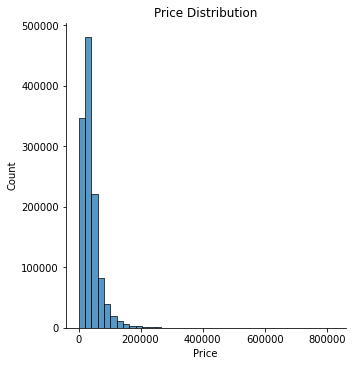

In [53]:
plt.figure()
sns.displot(train['transaction_real_price'], bins=40)
plt.xlabel('Price')
plt.title('Price Distribution')
plt.show()

In [54]:
#한쪽에 치우친 모양 -> 로그 변환 통해 정규화

train['log_price'] = np.log1p(train['transaction_real_price'])
real_price = train['transaction_real_price']#원래가격 따로 저장
train.drop('transaction_real_price', axis=1, inplace=True)
train.head(5)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,transformed,log_price
0,0,7622,1.0,137,17,84.82,41,0,6,13,False,10.532123
1,1,5399,1.0,64,17,99.17,12,0,10,1,False,9.903538
2,2,3578,1.0,64,17,84.74,46,0,10,13,False,10.558439
3,3,10957,1.0,13,17,146.39,42,0,19,55,False,11.678448
4,4,10639,1.0,13,17,194.43,43,0,7,15,False,11.695255


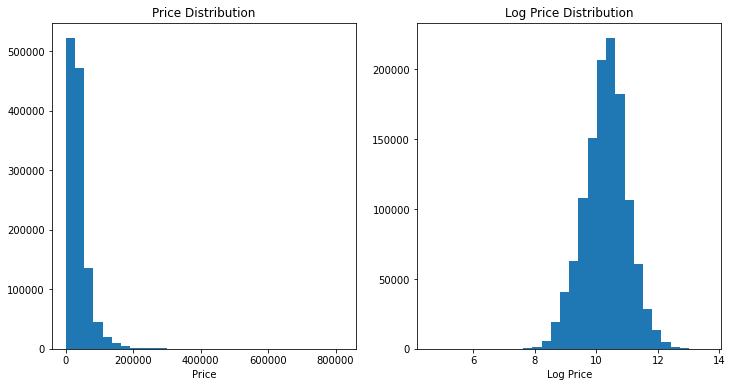

In [55]:
#그래프 그려 변환 확인

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

### Area

<Figure size 432x288 with 0 Axes>

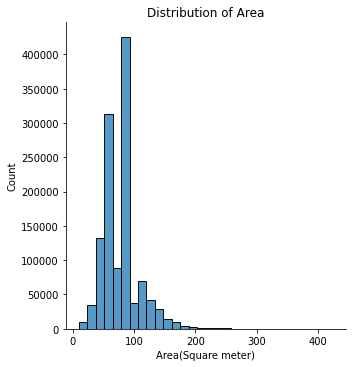

In [56]:
#train area
plt.figure()
sns.displot(train['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [57]:
#area도 로그변환 후, 따로 원래값 저장해두기
train['log_area'] = np.log1p(train['exclusive_use_area'])
test['log_area'] = np.log1p(test['exclusive_use_area'])

area = train['exclusive_use_area']

train.drop('exclusive_use_area', axis=1, inplace=True)
test.drop('exclusive_use_area', axis=1, inplace=True)

train.head(5)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,transformed,log_price,log_area
0,0,7622,1.0,137,17,41,0,6,13,False,10.532123,4.452252
1,1,5399,1.0,64,17,12,0,10,1,False,9.903538,4.606869
2,2,3578,1.0,64,17,46,0,10,13,False,10.558439,4.451319
3,3,10957,1.0,13,17,42,0,19,55,False,11.678448,4.993082
4,4,10639,1.0,13,17,43,0,7,15,False,11.695255,5.275202


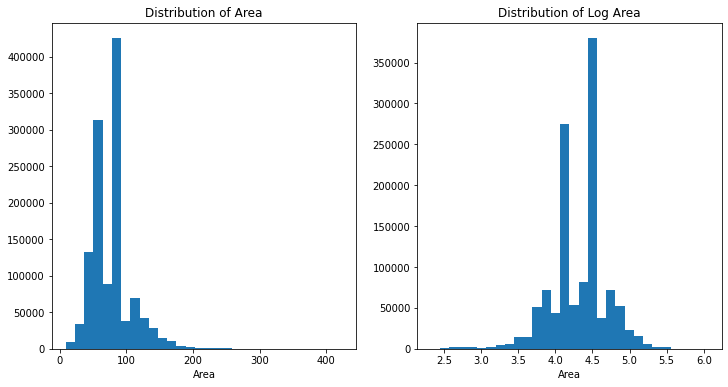

In [58]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(train['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

### city

In [59]:
train['city']=train['city'].map(lambda x:1 if x=='서울특별시' else 0)
test['city'] = test['city'].map(lambda x:1 if x=='서울특별시' else 0)

In [60]:
drop_col = ['transaction_id', 'apartment_id', 'apt_counts','transformed']
train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)
train.head(5)

,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
0,0,137,17,41,0,6,10.532123,4.452252
1,0,64,17,12,0,10,9.903538,4.606869
2,0,64,17,46,0,10,10.558439,4.451319
3,0,13,17,42,0,19,11.678448,4.993082
4,0,13,17,43,0,7,11.695255,5.275202


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  object 
 2   apt                     1216553 non-null  object 
 3   year_of_completion      1216553 non-null  int64  
 4   transaction_year_month  1216553 non-null  int64  
 5   floor                   1216553 non-null  int64  
 6   log_price               1216553 non-null  float64
 7   log_area                1216553 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 123.5+ MB


In [62]:
print(train.shape, test.shape)

(1216553, 8) (5463, 7)


# Modeling

교재 내의 housing 데이터셋과는 달리, 이 데이터는 거래연월이 있기 때문에 시계열 데이터로 볼 수 있음. 시게열 데이터를 사용할 때에는, 미래의 값으로 과거의 값을 예측하지 않도록 조심해야함! -> TimeSeriesSplit 기법을 사용. 이 폴드 방법에서는 앞에서부터 끊어서 학습하고 검증함. 미래의 값을 학습에 이용하지 않고, 검증에만 이용하는 방법!


**사용할 모델**
1. 선형회귀모델
2. 결정나무
3. 랜덤포레스트
4. xgboost
5. lightgbm

이정도만 사용해서 다섯개를 비교해보자.

먼저 rmse를 측정할 수 있도록 함수 만들어야 함


In [63]:
train_X, train_y = train.drop('log_price',axis=1), train['log_price']
print(train_X.shape, train_y.shape)

(1216553, 7) (1216553,)


In [64]:
def RMSE(y,y_pred):
  rmse = mean_squared_error(y, y_pred)**0.5 #root
  return rmse

def rmse_cv(model):
  #cv별로 학습하도록 만듦
  tscv = TimeSeriesSplit(n_splits=10)
  rmse_list = []
  model_name = model.__class__.__name__
  for _,(train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1),
                                          desc=f'{model_name} Cross Validations...',total=10):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    clf = model.fit(X_train, y_train)
    pred = clf.predict(X_test)
    rmse = RMSE(y_test, pred)
    rmse_list.append(rmse)
  return model_name, rmse_list

def print_rmse_score(model):
  #cv별 프린팅, 평균을 저장
  model_name, score = rmse_cv(model)
  for i, r in enumerate(score, start=1):
    print(f'{i} folds : {model_name} RMSLE : {r:.4f}')
  print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
  print('='*40)
  return model_name, np.mean(score)

In [65]:
reg = LinearRegression(n_jobs=-1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)

In [66]:
models = []
scores = []
for model in [reg, DTree, rf]:
  model_name, mean_score = print_rmse_score(model)
  models.append(model_name)
  scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


1 folds : LinearRegression RMSLE : 0.1965
2 folds : LinearRegression RMSLE : 0.2553
3 folds : LinearRegression RMSLE : 0.2209
4 folds : LinearRegression RMSLE : 0.3643
5 folds : LinearRegression RMSLE : 0.3418
6 folds : LinearRegression RMSLE : 0.4219
7 folds : LinearRegression RMSLE : 0.3855
8 folds : LinearRegression RMSLE : 0.3259
9 folds : LinearRegression RMSLE : 0.2739
10 folds : LinearRegression RMSLE : 0.2840

LinearRegression mean RMSLE: 0.3070


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


1 folds : DecisionTreeRegressor RMSLE : 0.1900
2 folds : DecisionTreeRegressor RMSLE : 0.2705
3 folds : DecisionTreeRegressor RMSLE : 0.2243
4 folds : DecisionTreeRegressor RMSLE : 0.3638
5 folds : DecisionTreeRegressor RMSLE : 0.3957
6 folds : DecisionTreeRegressor RMSLE : 0.4744
7 folds : DecisionTreeRegressor RMSLE : 0.3856
8 folds : DecisionTreeRegressor RMSLE : 0.3445
9 folds : DecisionTreeRegressor RMSLE : 0.3255
10 folds : DecisionTreeRegressor RMSLE : 0.3353

DecisionTreeRegressor mean RMSLE: 0.3310


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:36<05:29, 36.61s/it]/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [01:54<08:08, 61.10s/it]/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
RandomForestRegressor Cross Validations...

1 folds : RandomForestRegressor RMSLE : 0.1815
2 folds : RandomForestRegressor RMSLE : 0.2515
3 folds : RandomForestRegressor RMSLE : 0.2186
4 folds : RandomForestRegressor RMSLE : 0.3634
5 folds : RandomForestRegressor RMSLE : 0.3656
6 folds : RandomForestRegressor RMSLE : 0.4115
7 folds : RandomForestRegressor RMSLE : 0.3429
8 folds : RandomForestRegressor RMSLE : 0.3018
9 folds : RandomForestRegressor RMSLE : 0.3086
10 folds : RandomForestRegressor RMSLE : 0.2560

RandomForestRegressor mean RMSLE: 0.3001


In [67]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.307008
1,DecisionTreeRegressor,0.330968
2,RandomForestRegressor,0.300126


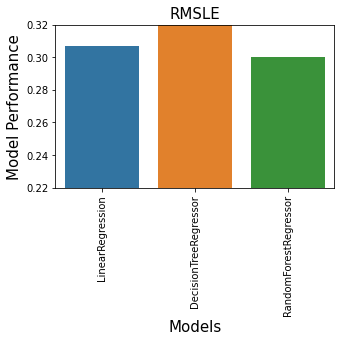

In [68]:
f, ax = plt.subplots(figsize=(5, 3))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

In [71]:
#특성 중요도
 feature_importances = rf.feature_importances_

IndentationError: ignored

In [72]:
feature_importances

array([0.        , 0.66814874, 0.00126933, 0.03217631, 0.03830866,
       0.00099778, 0.25909917])

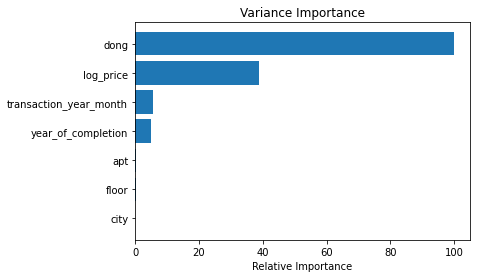

In [76]:
feature_importance = 100.0*(feature_importances/feature_importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+.5

plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variance Importance')
plt.show()